<a href="https://colab.research.google.com/github/bibin001/Deep-Learning/blob/main/handwrittenDigit_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#Convert MNIST data to tensors of 4D (#of images, height, width and colour channels)
transform=transforms.ToTensor()

In [3]:
#Train data (MNIST data is available in torchvision dataset.)
train_data=datasets.MNIST(root='/content/gdrive/My Drive/Colab Notebooks/Computer Vision/examples/cnn_mnist_data', train=True, download=True, transform=transform)

In [4]:
#Test data (MNIST data is available in torchvision dataset.)
test_data=datasets.MNIST(root='/content/gdrive/My Drive/Colab Notebooks/Computer Vision/examples/cnn_mnist_data', train=False, download=True, transform=transform)

In [5]:
#Create small batch size for images.. say 10
train_loader=DataLoader(train_data, batch_size=10, shuffle=True)
test_loader=DataLoader(test_data, batch_size=10, shuffle=False)

In [6]:
#Define CNN model
#Describe convolution layes and whats it doing (2 convolution layer)
#THIS IS JUST EXAMPLE for a single image... GO TO ### MODEL CLASS

conv1 = nn.Conv2d(1,8,3,1)
conv2 = nn.Conv2d(8,18,3,1)

In [7]:
#Grab 1 MNIST record (image)

for i, (X_train, y_train) in enumerate(train_data):
  break

In [8]:
print('Shape of one image:', X_train.shape)
x=X_train.reshape(1,1,28,28)  #first 1 is for batch.
print('Shape of reshaped image:', x.shape)

Shape of one image: torch.Size([1, 28, 28])
Shape of reshaped image: torch.Size([1, 1, 28, 28])


In [9]:
#Perform our first convolution
x=F.relu(conv1(x)) #relu as activation function

In [10]:
x.shape #1 is single image, 6 no of filters, 26,26 is the dimension

torch.Size([1, 8, 26, 26])

In [11]:
#pass through the pooling layer
x = F.max_pool2d(x,2,2)

In [12]:
x.shape

torch.Size([1, 8, 13, 13])

In [13]:
#do our second convolution
x=F.relu(conv2(x))

In [14]:
x.shape

torch.Size([1, 18, 11, 11])

In [15]:
#pass through pooling layer
x= F.max_pool2d(x, 2, 2)

In [16]:
x.shape #11/2=5.5 but we have to round down to 5 as we cannot invent data to round up

##########EXAMPLE OF ONE IMAGE OPERATION OF CONV AND POOLING OVER TO GET SHAPES OF IMAGES

torch.Size([1, 18, 5, 5])

In [17]:
#MODEL CLASS
class convNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1=nn.Conv2d(1,6,3,1)
    self.conv2=nn.Conv2d(6,16,3,1)
    #Fully connected layer
    self.fc1=nn.Linear(5*5*16, 120) ##(16,5,5) is the shape of image after last pooling function. see just above.
    self.fc2=nn.Linear(120, 70)
    self.fc3=nn.Linear(70, 10)

  def forward(self,X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2)
    #two convolution layer and two pooling completed
    #Now Flatten X (Data)
    X=X.view(-1,16*5*5) #16*5*5 dimension/shape of image after last pooling, -1 is used to vary the batch size

    #Fully Conneceted Layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    return F.log_softmax(X, dim=1)


In [18]:
#Create instance of our Model
torch.manual_seed(41)
model= convNet()
model

convNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=70, bias=True)
  (fc3): Linear(in_features=70, out_features=10, bias=True)
)

In [19]:
#Loss function & Optimizer
criterion= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
import time
start_time=time.time()

#Create variables to track things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

#For loop for epochs
for i in range(epochs):
  trn_corrct = 0
  tst_correct = 0

  #Train
  for b,(X_train, y_train) in enumerate(train_loader):
    b+=1 #start our batches at 1
    y_pred=model(X_train)
    loss= criterion(y_pred,y_train)

    predicted=torch.max(y_pred.data,1)[1] #ass up the number of correct predictions
    batch_correct= (predicted == y_train).sum() #How many we got correct from this batch, True=1, False=0, sum it up
    trn_corrct+= batch_correct #Keep track as we go along training


    #update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #print our results
    if b%600 ==0:
      print(f'Epoch: {i}, Batch: {b}, Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corrct)

  #Test
  with torch.no_grad():
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val=model(X_test)

      predicted=torch.max(y_val.data,1)[1] #add up the number of correct predictions
      tst_correct+= (predicted == y_test).sum() #How many we got correct from this batch, True=1, False=0, sum it up

  loss=criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_correct)



current_time=time.time()
total_time= current_time-start_time
print(f'Training took {total_time/60} minutes!')

Epoch: 0, Batch: 600, Loss: 0.3765566945075989
Epoch: 0, Batch: 1200, Loss: 0.5164510011672974
Epoch: 0, Batch: 1800, Loss: 0.018596014007925987
Epoch: 0, Batch: 2400, Loss: 0.0073001692071557045
Epoch: 0, Batch: 3000, Loss: 0.1986463963985443
Epoch: 0, Batch: 3600, Loss: 0.10770054161548615
Epoch: 0, Batch: 4200, Loss: 0.01655733585357666
Epoch: 0, Batch: 4800, Loss: 0.039656832814216614
Epoch: 0, Batch: 5400, Loss: 0.004006581846624613
Epoch: 0, Batch: 6000, Loss: 0.0347854420542717
Epoch: 1, Batch: 600, Loss: 0.003279051510617137
Epoch: 1, Batch: 1200, Loss: 0.0008063906570896506
Epoch: 1, Batch: 1800, Loss: 0.00830929446965456
Epoch: 1, Batch: 2400, Loss: 0.07041387259960175
Epoch: 1, Batch: 3000, Loss: 0.07094080746173859
Epoch: 1, Batch: 3600, Loss: 0.17314305901527405
Epoch: 1, Batch: 4200, Loss: 0.0005820575752295554
Epoch: 1, Batch: 4800, Loss: 0.0006530469981953502
Epoch: 1, Batch: 5400, Loss: 0.2820059657096863
Epoch: 1, Batch: 6000, Loss: 0.0016632291954010725
Epoch: 2, Bat

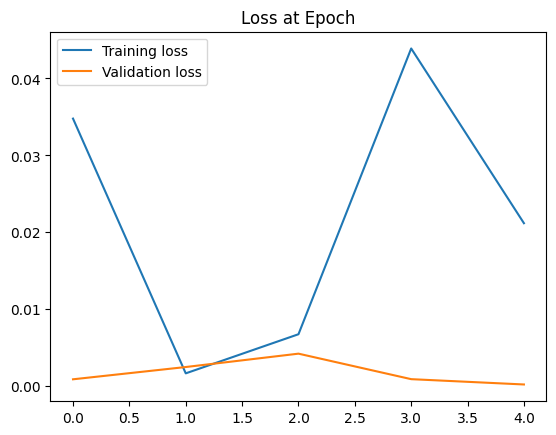

In [21]:
#Graph loss at epoch
train_losses= [tl.item() for tl in train_losses]
plt.plot(train_losses,label='Training loss')
plt.plot(test_losses,label='Validation loss')
plt.title("Loss at Epoch")
plt.legend()


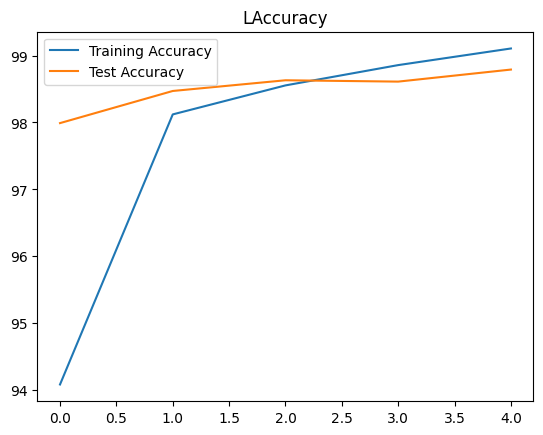

In [22]:
#graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label='Training Accuracy')
plt.plot([t/100 for t in test_correct], label='Test Accuracy')
plt.title("LAccuracy")
plt.legend()

In [23]:
test_load_everything= DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
  correct=0
  for X_test, y_test in test_load_everything:
    y_val= model(X_test)
    predicted= torch.max(y_val,1)[1]
    correct+= (predicted==y_test).sum()

In [24]:
#Did for correct
(correct.item()/len(X_test))*100

98.79

In [25]:
#grab an image
test_data[3030] #Tensor with an image in it... at the end it shows the label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [26]:
#Grab just the data
test_data[3030][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [27]:
#Reshape it
test_data[3030][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

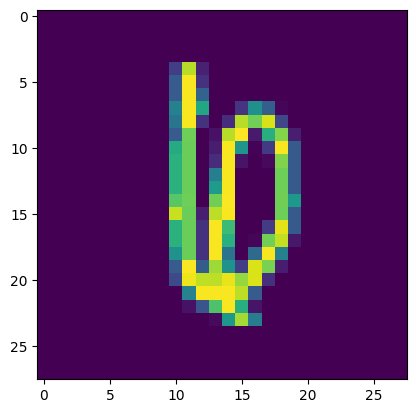

In [28]:
plt.imshow(test_data[3030][0].reshape(28,28))

In [29]:
# Pass image to our model
model.eval()
with torch.no_grad():
  new_prediction=model(test_data[3030][0].view(1,1,28,28)) #batch size of 1, 1 color channel, 28x28 image

In [30]:
#check the predicted values and probabilities
new_prediction

tensor([[ -2.2784,  -8.0868,  -8.1370,  -7.4851,  -6.2963,  -5.9994,  -0.1154,
         -14.2641,  -6.9584,  -8.9412]])

In [31]:
new_prediction.argmax()

tensor(6)